In [1]:
# # https://pypi.org/project/quickdraw
# from quickdraw import QuickDrawData
import numpy as np
import urllib.request
import os
import glob as gb
import pathlib
import random
import torch
import matplotlib
import matplotlib.pyplot as plt
import time
import torch.nn as nn
from torch import optim
from torchsummary import summary
from torch.utils.data import DataLoader

# import custom data / utils
from data import *
from utils import *
from models.model import *
from train import *

In [2]:
set_seed(1)

## Prepare Dataset

In [10]:
load_dataset()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/airplane.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/apple.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/banana.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bear.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bicycle.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bird.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bus.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cup.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dog.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/duck.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/fish.npy
ht

## Check Device & Hyperparameter

In [3]:
DEVICE = check_device()

Using Pytorch version :  1.12.1 DEVICE :  cuda


In [4]:
# hyperparameter
BATCH_SIZE = 64
EPOCHS = 30
LEARING_RATE = 1e-4
WEIGHT_DECAY = 1e-3

## Data Loader

In [6]:
dataset, train_dataset, val_dataset, test_dataset, classes = prepare_dataset()

Means: tensor([0.1702])
STDs: tensor([0.3224])


In [ ]:
# remove npy files
def remove_dataset(npy_files_path='./dataset/*.npy'):
    npy_files = gb.glob(npy_files_path)
    for npy_file in npy_files:
        os.remove(npy_file)
        
    print('remove files')
    
remove_dataset()

remove files


In [14]:
count_dict = {c : 0 for c in classes}

def idx_to_class(y_idx):
  return classes[int(y_idx.item())]

for _, labels in train_dataset:
  label = idx_to_class(labels)
  count_dict[label] += 1
  
print(count_dict)

{'airplane': 8000, 'apple': 8000, 'banana': 8000, 'baseball': 8000, 'bear': 8000, 'bicycle': 8000, 'bird': 8000, 'bus': 8000, 'cat': 8000, 'cup': 8000, 'dog': 8000, 'duck': 8000, 'fish': 8000, 'flower': 8000, 'hamburger': 8000, 'house': 8000, 'ice_cream': 8000, 'light_bulb': 8000, 'lion': 8000, 'monkey': 8000, 'moon': 8000, 'nose': 8000, 'pencil': 8000, 'pig': 8000, 'rabbit': 8000, 'shoe': 8000, 'spider': 8000, 'sun': 8000, 'tree': 8000, 'umbrella': 8000}


save figure:  train_dataet_distribution


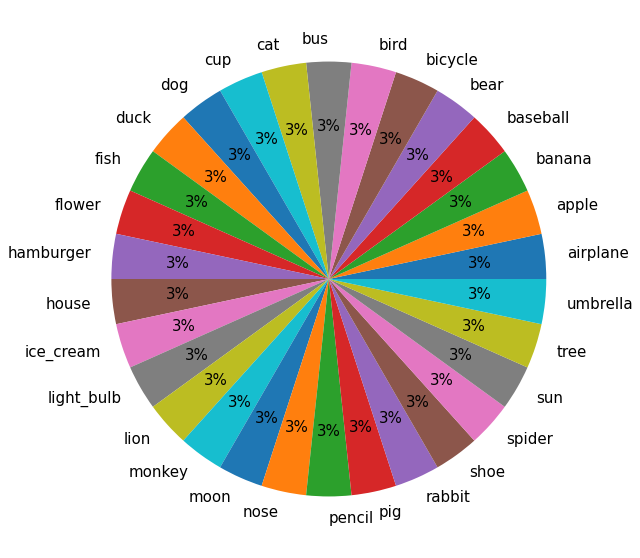

In [15]:
classes = list(count_dict.keys())
count = list(count_dict.values())

#https://ehclub.net/677
plt.figure(figsize=(10, 10))
textprops = dict(size=15, weight=3,)
plt.pie(count, labels=classes, autopct='%.f%%', pctdistance=0.7, textprops=textprops);

save_figure('train_dataset_distribution')

In [7]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
for (X_train, y_train) in train_loader:
  print(f'Shape of X_train [N, C, H, W] : {X_train.shape}', f'\nType of X_train : {X_train.dtype}\n')  # X_train.type() : torch.FloatTensor
  print(f'Shape of y_train [N, C, H, W] : {y_train.shape}', f'\nType of y_train : {y_train.dtype}\n')  # y_traon.type() : torch.LongTensor
  break

Shape of X_train [N, C, H, W] : torch.Size([64, 1, 28, 28]) 
Type of X_train : torch.float32

Shape of y_train [N, C, H, W] : torch.Size([64]) 
Type of y_train : torch.float32



## Data Visualization

save figure:  pig


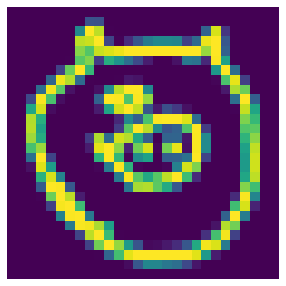

In [18]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

imshow(images[0], idx_to_class(labels[0]))

save figure:  quickdraw_visualization


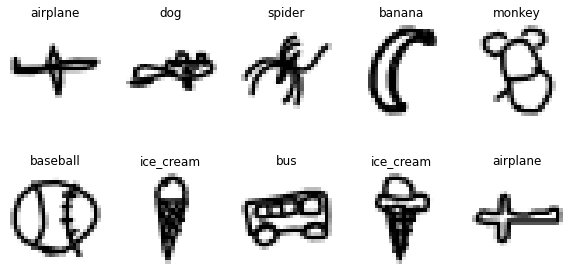

In [15]:
plt.figure(figsize=(10, 5))

for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.imshow(X_train[i, :, :, :].squeeze(), cmap='binary')  # X_train [32, 1, 28, 28] -> [i, :, :, :] -> squeeze() -> [28, 28]
  plt.title(idx_to_class(y_train[i]))
  
save_figure('quickdraw_visualization')

## Model

In [16]:
model = SimpleCNN()

In [10]:
model = model.to(DEVICE)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             800
              ReLU-2           [-1, 32, 24, 24]               0
         MaxPool2d-3           [-1, 32, 12, 12]               0
            Conv2d-4             [-1, 64, 8, 8]          51,200
              ReLU-5             [-1, 64, 8, 8]               0
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Linear-7                  [-1, 512]         524,800
           Dropout-8                  [-1, 512]               0
            Linear-9                  [-1, 128]          65,664
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 30]           3,870
Total params: 646,334
Trainable params: 646,334
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [11]:
optimizer = optim.AdamW(model.parameters(), lr=LEARING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.001)

criterion = nn.CrossEntropyLoss()

## Train

In [12]:
train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []

In [13]:
#check best validation loss
best_val_loss = float('inf')

training_start_time = training_start_time = time.time()

for epoch in range(EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train(model, train_loader, criterion, optimizer,DEVICE)
    val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE)
    
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    scheduler.step()
    
    #Saving model whenver the best validation loss is obtained
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './models/pt/model.pt')
    
    #check time
    end_time = time.time()
    epoch_mins, epoch_secs,  = epoch_time(start_time, end_time) 
    
  
    print(f'\nEpoch: {epoch+1:02}/{EPOCHS} Time: {epoch_mins}m {epoch_secs}s')
    print('========================= Train =========================')
    print(f'Train Loss: {train_loss:.3f} Train Accuracy: {train_acc*100:.3f}%')
    print('======================= Validation ======================')
    print(f'Validation Loss: {val_loss:.3f} Validation Accuracy: {val_acc*100:.3f}%')

total_trainig_time = time.time() - training_start_time
print(f'\nDone! Total Training Time: {total_trainig_time//60:.0f}m {total_trainig_time%60:.0f}s')
print(f'Best Validation Loss: {best_val_loss:3f}')


Epoch: 01/30 Time: 2m 39s
========================= Train =========================
Train Loss: 1.480 Train Accuracy: 59.291%
======================= Validation ======================
Validation Loss: 0.917 Validation Accuracy: 74.409%

Epoch: 02/30 Time: 2m 25s
========================= Train =========================
Train Loss: 0.952 Train Accuracy: 73.349%
======================= Validation ======================
Validation Loss: 0.771 Validation Accuracy: 78.419%

Epoch: 03/30 Time: 2m 45s
========================= Train =========================
Train Loss: 0.828 Train Accuracy: 76.615%
======================= Validation ======================
Validation Loss: 0.699 Validation Accuracy: 80.085%

Epoch: 04/30 Time: 2m 35s
========================= Train =========================
Train Loss: 0.761 Train Accuracy: 78.431%
======================= Validation ======================
Validation Loss: 0.665 Validation Accuracy: 80.981%

Epoch: 05/30 Time: 2m 35s
=========================

save figure:  simple_cnn_2_loss_acc


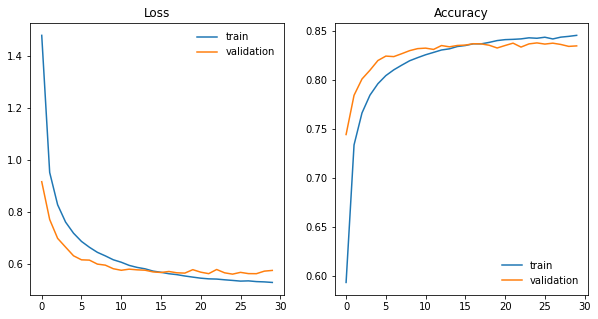

In [19]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.title('Loss')
plt.legend(frameon=False)


plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train')
plt.plot(val_acc_list, label='validation')
plt.title('Accuracy')
plt.legend(frameon=False)
save_figure('simple_cnn_2_loss_acc')

plt.show()